In [ ]:
#!L
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torch.utils.tensorboard import SummaryWriter
import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# Data

Для обучения сеток мы будем использовать MNIST.

Качаем архив [Google Drive](https://drive.google.com/file/d/1xo-AIG2E6cTZbWGti1A5lp5FDtf4aHx_/view?usp=sharing). 
Его структура следующая:
- /
    - /train.csv
    - /val.csv
    - /train/{image_name}.png
    - /val/{image_name}.png

CSV файлы содержат название файла и его лейбл: image_name, label.

Распакуйте архив в текущую папку:
`unzip -q ./mnist_data2.zip -d ./`

In [2]:
#!L
class MNISTDataset(Dataset):
    def __init__(self, images_dir_path: str,
                 description_csv_path: str):
        super().__init__()
        
        self.images_dir_path = images_dir_path
        self.description_df = pd.read_csv(description_csv_path,
                                           dtype={'image_name': str, 'label': int})

    def __len__(self):
        return len(self.description_df)
    
    def __getitem__(self, index):
        img_name, label = self.description_df.iloc[index, :]
        
        img_path = Path(self.images_dir_path, f'{img_name}.png')
        img = self._read_img(img_path)
        
        return dict(sample=img, label=label)
    
    @staticmethod
    def _read_img(img_path: Path):
        img = cv2.imread(str(img_path.resolve()))
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))
        
        return img

## Задание 1
**(0.4 балла)** Запустите обучение сети в ячейках ниже. За 10 эпох метрика на валидации вырастает всего до ~0.15.

*Вопросы:*
1. Почему сетка так плохо учится?
1. Найдите ошибку в коде и объясните ошибка вызывает подобное поведение в обучении?

*Requirements:*
1. Напишите ответы в markdown ячейке перед следующим заданием
1. В следующей ячейке (после вашего ответа) вставьте код с исправлением ошибки.

In [3]:
#!L
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        # поменяем папку логов
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=False, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)
            print(val_loss, val_metrics)

In [4]:
#!L
mnist_train = MNISTDataset(images_dir_path='mnist_data/train/',
                           description_csv_path='mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='mnist_data/val/',
                         description_csv_path='mnist_data/val.csv')

model = ResNet18()
opt = optim.SGD(model.parameters(), lr=1e-2)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='logs/exp1/') # сразу поменяю расположение логов

In [5]:
#!L
trainer.train(10)

7.538392203188018 0.11085838607594936
7.356994332209276 0.11085838607594936
7.301390398423411 0.11085838607594936
7.23694809612264 0.11105617088607594
6.962206550266688 0.11244066455696203
6.8946972895543315 0.11728639240506329
6.768098488043334 0.12203322784810126
6.649350144016214 0.12767009493670886
6.682237913849752 0.12974683544303797
6.7300650096745995 0.12717563291139242


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


![image.png](attachment:7bc4a7e3-9eda-47f1-a4ef-d44d5173793d.png)

С первого взгляда ничего примечательно не видно, вроде модель хорошая, трейнер все тот же. Только почему-то модель у нас не учится. Точнее переобучается и очень хорошо подстраивается под обучающую выборку, что собственно и видно на тензорборде. Подозрительно, что мы используем какую-то вторую версию мниста, может у нас данные отличаются чем-то? Давайте проверим.

In [6]:
#!L
mnist = pd.read_csv('mnist_data/train.csv')
print(mnist.label.head(1000).nunique())
mnist.head(1000)

1


,image_name,label
0,30207,0
1,5662,0
2,55366,0
3,14160,0
4,14161,0
...,...,...
995,46980,0
996,56662,0
997,35050,0
998,23643,0


In [7]:
#!L
print(mnist.label.tail(1000).nunique())
mnist.tail(1000)

1


,image_name,label
59000,51688,9
59001,25248,9
59002,25247,9
59003,25239,9
59004,25237,9
...,...,...
59995,5503,9
59996,52034,9
59997,23285,9
59998,15728,9


Получается, что в данных и у нас отсутствует шафл (перестановка), и если внимательно посмотреть теперь на трейнер, то мы увидим, что там шафл там тоже отсутствует. Давайте включим его. Это должно исправить ошибку.

In [34]:
#!L
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        # поменяем папку логов
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size) # <----- Вот здесь мы поправили код.
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)
            print(val_loss, val_metrics)

In [35]:
#!L
mnist_train = MNISTDataset(images_dir_path='mnist_data/train/',
                           description_csv_path='mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='mnist_data/val/',
                         description_csv_path='mnist_data/val.csv')

model = ResNet18()
opt = optim.SGD(model.parameters(), lr=1e-2)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='logs/exp1/') # сразу поменяю расположение логов

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:754: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [36]:
#!L
trainer.train(10)

0.0665072247008734 0.9783425632911392
0.04802656240608025 0.9849683544303798
0.04020262728710482 0.9877373417721519
0.037692608674280814 0.9876384493670886
0.034011251518953754 0.9895174050632911
0.03562875394046283 0.9887262658227848
0.03524441342145835 0.9892207278481012
0.03514057427093599 0.9889240506329114
0.03350194129349422 0.9890229430379747
0.03408709097719203 0.9901107594936709


100%|██████████| 79/79 [00:17<00:00,  4.50it/s]
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:754: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


Да, все супер!

## Задание 2
**(0.2 балла)** Запустите обучение сети в ячейках ниже. За 10 эпох сетка не покажет качества выше случайного угадывания.

*Вопросы:*
1. Почему сетка так плохо учится?
1. Найдите ошибку в коде и объясните почему найденная ошибка вызывает подобное поведение в обучении?

*Requirements:*
1. Напишите ответы в markdown ячейке перед следующим заданием
1. В следующей ячейке (после вашего ответа) вставьте код с исправлением ошибки.

In [11]:
#!L
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        # поменяем папку логов
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)
            print(val_loss, val_metrics)

In [12]:
#!L
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
opt = optim.SGD(model.parameters(), lr=10e-2, weight_decay=9e-1)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='logs/exp2/') # сразу поменяю расположение логов

In [13]:
#!L
trainer.train(10)

2.3026036069362976 0.09988132911392406
2.3022562974615943 0.11224287974683544
2.302350346046158 0.11224287974683544
2.302108293847193 0.11224287974683544
2.3023165720927565 0.09473892405063292
2.3022591615025 0.11224287974683544
2.3024794663055035 0.10166139240506329
2.302141023587577 0.11224287974683544
2.302522067782245 0.11224287974683544
2.3024349997315228 0.11224287974683544


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


Метод пристального взгляда позволяет обнаружить, что у нас увеличился LR в этом задании, да еще и добавилась регуляризация. При слишком большом LR возможно, что мы не можем сойтись к минимуму. Но на самом деле кажется, что тут проблема вовсе не в LR, а в большой $L_2$ регуляризации, которая очень сильно штрафует нашу модель, не позволяя ей выдавать хорошее значение метрики. Давайте посмотрим сначала на график LR, и, если у нас проблема не с LR будем уменьшать регуляризацию.

In [14]:
#!L

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        # поменяем папку логов
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)
            print(val_loss, val_metrics)
            
            
    def find_lr(self, min_lr: float = 1e-6,
                    max_lr: float = 1e-1,
                    num_lrs: int = 20,
                    smooth_beta: float = 0.8) -> dict:
            lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
            logs = {'lr': [], 'loss': [], 'avg_loss': []}
            avg_loss = None
            model, optimizer = self.model, self.optimizer
            train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

            model.train()
            for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
                # apply new lr
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = lr

                # train step
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # calculate smoothed loss
                if avg_loss is None:
                    avg_loss = loss
                else:
                    avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

                # store values into logs
                logs['lr'].append(lr)
                logs['avg_loss'].append(avg_loss)
                logs['loss'].append(loss)

            for k, v in logs.items():
                for i in range(len(v)):
                    self.log_writer.add_scalar(k, v[i], global_step=self.global_step)
                    self.global_step += 1

            logs.update({key: np.array(val) for key, val in logs.items()})

            return logs

In [15]:
#!L
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
opt = optim.SGD(model.parameters(), lr=10e-2, weight_decay=9e-1)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='logs/exp2/')

logs = trainer.find_lr(min_lr = 1e-3,
                max_lr = 0.5,
                num_lrs = 200,
                smooth_beta = 0.8)

finding LR: 100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


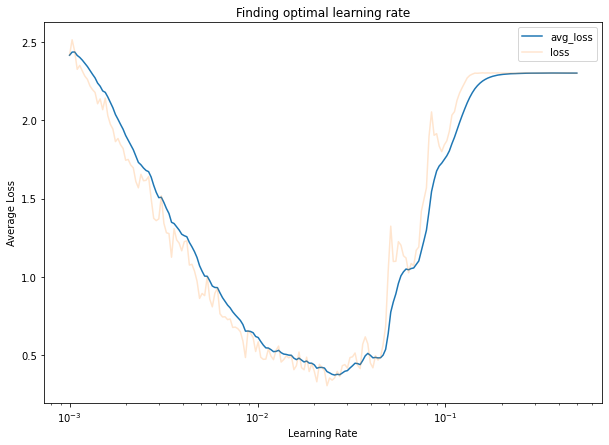

In [16]:
#!L
plt.figure(figsize=(10,7))
plt.plot(logs['lr'], logs['avg_loss'], label='avg_loss')
plt.plot(logs['lr'], logs['loss'], alpha=0.2, label='loss')
plt.xlabel('Learning Rate')
plt.ylabel('Average Loss')
plt.xscale('log')
plt.title('Finding optimal learning rate')
plt.legend()
plt.show()

Ну да, все дело в регуляризации, а LR можно даже немного увеличить) Давайте выставим $L_2$ регуляризацию на уровне 0.001. Данные у нас простые, для них в принципе не нужна регуляризация. Но мы попробуем улучшить скор.

In [17]:
#!L
model = ResNet18()
opt = optim.SGD(model.parameters(), lr=3e-2, weight_decay= 0.001) # <---- вот тут увеличил LR и уменьшил регуляризацию

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='logs/exp2/')

In [18]:
#!L
trainer.train(10)

100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


0.045778963207915614 0.9853639240506329
0.04081657190388658 0.9861550632911392
0.03222794713389093 0.9894185126582279
0.02704583418804598 0.991495253164557
0.025665635969364557 0.9918908227848101
0.03312142305044808 0.9908030063291139
0.026916304463870628 0.9925830696202531
0.027802260434903393 0.9927808544303798
0.028595786123931453 0.9915941455696202
0.025851706635646073 0.9930775316455697


## Задание 3
**(0.4 балла)** Запустите обучение сети в ячейках ниже. В сети будут использоваться предобученные параметры, которые должны были помочь выдавать качество около 1. Однако, за 5 эпох сетка не выдаст качество, которое мы ожидали.

Перед запуском ячеек скачайте используемое состояние модели [pretrained_model.pt](https://drive.google.com/file/d/1JITAz1L8mWpTGany84YMYKIhzVgsBf_9/view?usp=sharing).

*Вопросы:*
1. Почему сетка так плохо учится?
1. Найдите ошибку и объясните почему найденная ошибка вызывает подобное поведение в обучении?

*Requirements:*
1. Напишите ответы в markdown ячейке после ячейки с тензорбордом.
1. В следующей ячейке (после вашего ответа) вставьте код с исправлением ошибки.

In [19]:
#!L
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] #/ 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        # поменяем папку логов
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
        
    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)
            print(val_loss, val_metrics)

In [27]:
#!L
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
model_sate_path = 'pretrained_model.pt'
model.load_state_dict(torch.load(model_sate_path, map_location='cpu'))

opt = optim.SGD(model.parameters(), lr=1e-2)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val,  tboard_log_dir='logs/exp3/')

In [21]:
#!L
trainer.train(5)

100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


32687555869.16456 0.0882120253164557
527185497412.05066 0.09473892405063292
nan 0.09691455696202532
nan 0.09691455696202532
nan 0.09691455696202532


На тесте у нас лосс улетел в куда-то в атмосферу, поэтому логи только по трейну и только по доле верных ответов. 

Если модель не учится, а выдает +- средний ответ, то скорее всего где-то у нас занулены веса в нескольких операциях подряд. То есть градиенты не текут. Давайте проверять.

In [28]:
#!L
for k, v in model.named_parameters():
    if np.all(v.detach().cpu().numpy()) == 0:
        print(k, np.all(v.detach().cpu().numpy()) == 0)

net.layer2.0.conv1.weight True
net.layer2.0.bn1.weight True
net.layer2.0.bn1.bias True
net.layer2.0.conv2.weight True
net.layer2.0.bn2.weight True
net.layer2.0.bn2.bias True
net.layer2.0.downsample.0.weight True
net.layer2.0.downsample.1.weight True
net.layer2.0.downsample.1.bias True


Действительно, во втором слое есть множество операций, у которых вес нулевой. Решим задачу максимально тупо и просто поставим везде 1 за место 0. (научусь попозже писать циклы по весам, но пока так)

In [29]:
#!L
nn.init.constant_(model.net.layer2[0].conv1.weight, 1)
nn.init.constant_(model.net.layer2[0].bn1.weight, 1)
nn.init.constant_(model.net.layer2[0].bn1.bias, 1)
nn.init.constant_(model.net.layer2[0].conv2.weight, 1)
nn.init.constant_(model.net.layer2[0].bn2.weight, 1)
nn.init.constant_(model.net.layer2[0].bn2.bias, 1)
nn.init.constant_(model.net.layer2[0].downsample[0].weight, 1)
nn.init.constant_(model.net.layer2[0].downsample[1].weight, 1)
nn.init.constant_(model.net.layer2[0].downsample[1].bias, 1)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0', requires_grad=True)

Быстрая проверка...

In [30]:
#!L
for k, v in model.named_parameters():
    if np.all(v.detach().cpu().numpy()) == 0:
        print(k, np.all(v.detach().cpu().numpy()) == 0)

In [31]:
#!L
trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val,  tboard_log_dir='logs/exp3/')

trainer.train(5)

0.1461729282082966 0.9520371835443038
0.06677567041361163 0.9769580696202531
0.06265589975327536 0.9799248417721519
0.0509669053164912 0.9829905063291139
0.05531080008213279 0.9810126582278481


100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Ну да так намного лучше, хоть и не идеальное решение проблемы.